In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
plt.style.use('seaborn-notebook')
plt.style.use('ggplot')

In [4]:
import pymc3 as pm

# Note on using `PyMC3` as opposed to `statsmodels`

This chapters talks about the difference between `stan-glm` and `glm` in R, which finally revealed why when I was using `statsmodels` in the previous chapters, the standard errors are slightly off from the book: `statsmodel` uses classical fitting, whereas `stan-glm` uses Bayesian fitting and the "errors" were shown as `MAD_sd`. We will try to use `pyMC3` as the closest python relative in this notebook, and for the question that compares `stan-glm` to `glm`, we will be using `statsmodels` vs `pymc3`

# 8.1 Least Squares

In [5]:
data = pd.read_csv('../ROS-Examples/ElectionsEconomy/data/hibbs.dat', sep=' ')

In [6]:
data.head()

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon


In [7]:
def rss(x,y,a,b):
    resid = y-(a+b*x)
    return sum(np.power(resid,2))

In [8]:
a_fixed = 46.3 # a is intercept 
b_fixed = 3 #b is slope

In [9]:
x = data['growth']
y = data['vote']

In [10]:
a_free_rss = []
for a in np.linspace(20,80,100):
    a_free_rss.append(rss(x,y,a,b_fixed))

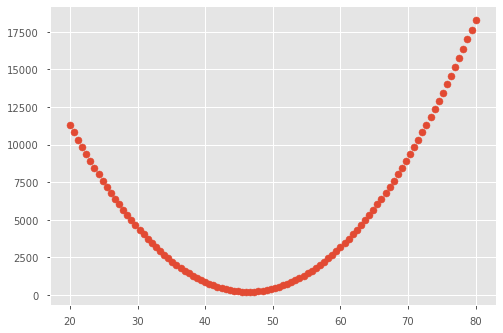

In [11]:
plt.scatter(np.linspace(20,80,100), a_free_rss)

In [12]:
b_free_rss = []
for b in np.linspace(1,10,100):
    b_free_rss.append(rss(x,y,a_fixed,b))

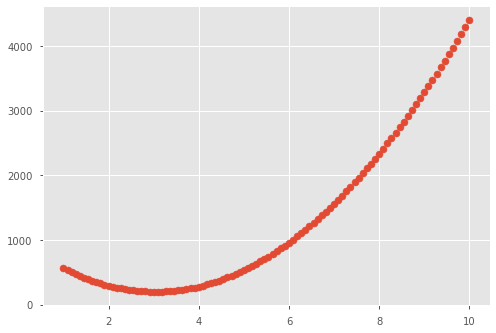

In [13]:
plt.scatter(np.linspace(1,10,100), b_free_rss)

# 8.2 Maximum Likelihood

In [14]:
def rss_lh(x,y,a,b,sigma):
    p = np.sum(-1/2*np.power((y-(a+b*x))/sigma,2)-np.log(sigma))    
    return p

In [15]:
sigma_true = np.sqrt(1/len(x)*np.sum(np.power(y-(a_fixed+b_fixed*x),2)))
sigma_true

3.521737852254197

In [16]:
sigma_classic = np.sqrt(1/(len(x)-2)*np.sum(np.power(y-(a_fixed+b_fixed*x),2)))
sigma_classic

3.764896128333803

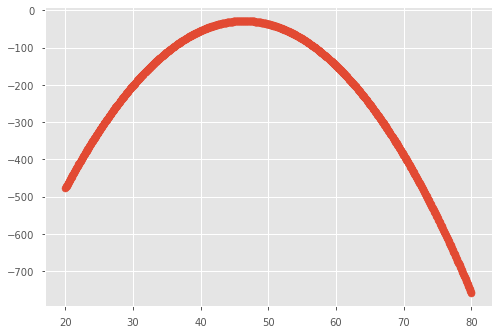

In [17]:
sample_space = np.linspace(20,80,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss_lh(x,y,a,b_fixed,sigma_true))
plt.scatter(sample_space, a_free_rss)

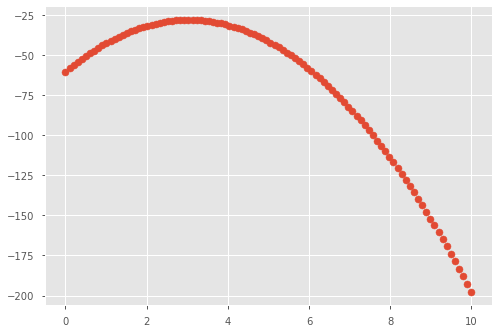

In [18]:
sample_space = np.linspace(0,10,100)
b_free_rss = []
for b in sample_space:
    b_free_rss.append(rss_lh(x,y,a_fixed,b,sigma_true))
plt.scatter(sample_space, b_free_rss)

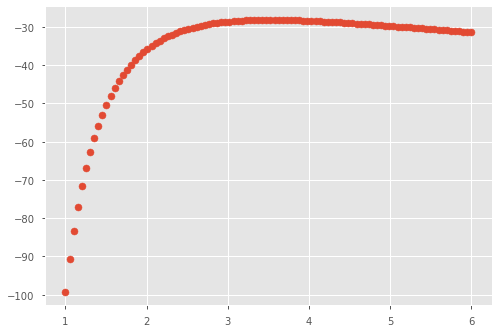

In [19]:
sample_space = np.linspace(1,6,100)
sigma_free_rss = []
for sigma in sample_space:
    sigma_free_rss.append(rss_lh(x,y,a_fixed,b_fixed,sigma))
plt.scatter(sample_space, sigma_free_rss)

# 8.3 Least Absolute deviation

In [20]:
def rss_abs(x,y,a,b):
    resid = y-(a+b*x)
    return sum(np.abs(resid))

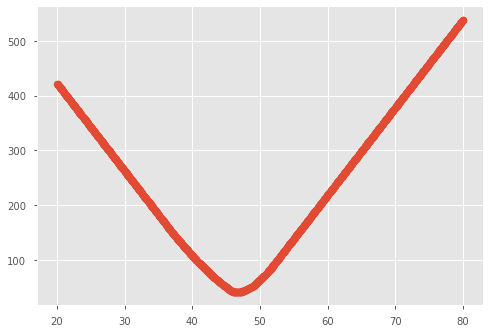

In [21]:
sample_space = np.linspace(20,80,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss_abs(x,y,a,b_fixed))
plt.scatter(sample_space, a_free_rss)

In [22]:
min(a_free_rss)

41.35999999999999

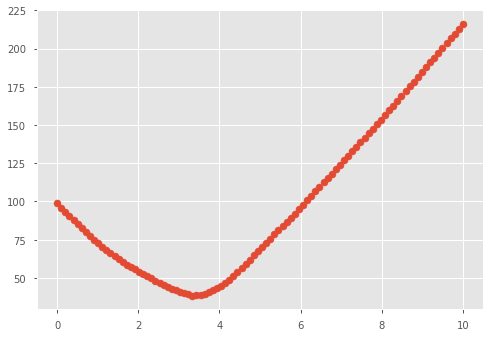

In [23]:
sample_space = np.linspace(0,10,100)
b_free_rss = []
for b in sample_space:
    b_free_rss.append(rss_abs(x,y,a_fixed,b))
plt.scatter(sample_space, b_free_rss)

In [24]:
min(b_free_rss)

38.35333333333332

# 8.4 Least squares and least absolute deviatioon

In [25]:
x = np.linspace(-10,10,100)
y = np.power(x,2)

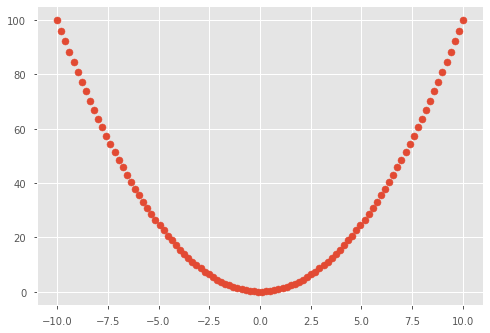

In [26]:
plt.scatter(x,y)

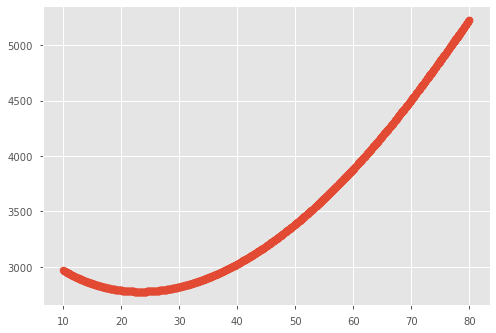

In [27]:
sample_space = np.linspace(10,80,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss_abs(x,y,a,b_fixed))
plt.scatter(sample_space, a_free_rss)

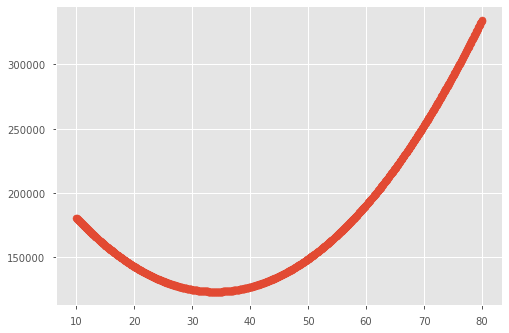

In [28]:
sample_space = np.linspace(10,80,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss(x,y,a,b_fixed))
plt.scatter(sample_space, a_free_rss)

Basically, if the model is not linear...if it is linear the two agrees

Okay maybe let's try big errors

In [29]:
x = np.linspace(-10,10,100)
y = 5*x+6+np.random.normal(0, 10, 100)

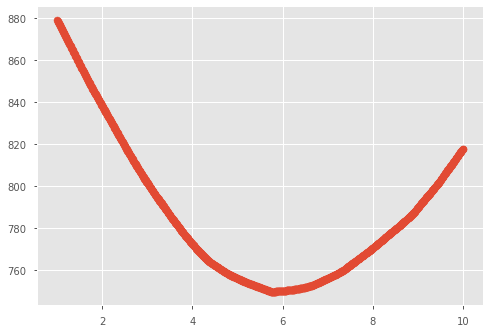

In [30]:
sample_space = np.linspace(1,10,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss_abs(x,y,a,5))
plt.scatter(sample_space, a_free_rss)

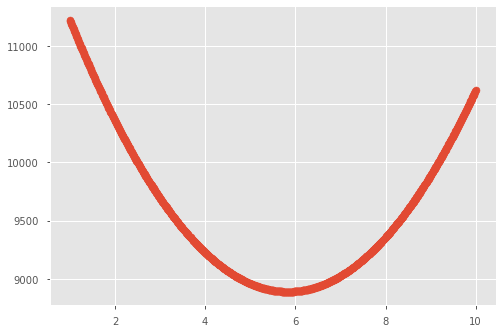

In [31]:
sample_space = np.linspace(1,10,1000)
a_free_rss = []
for a in sample_space:
    a_free_rss.append(rss(x,y,a,5))
plt.scatter(sample_space, a_free_rss)

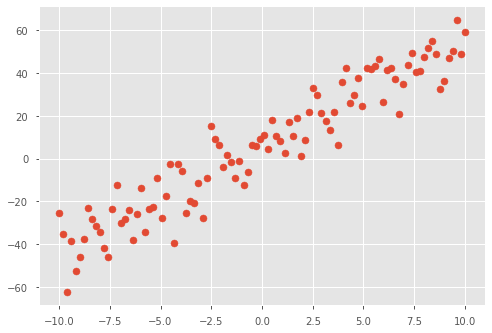

In [32]:
plt.scatter(x,y)

essentially we need big errors, so influenced by outliers

# 8.5 influence of individual data points

Skipping due to writing on the book, but it would be the biggest away point on the far end

# 8.6 Influence of individual data points

In [33]:
def influence_slope(x):
    x_bar = np.mean(x)
    return (x-x_bar)/np.sum(np.power(x-x_bar, 2))

In [34]:
x = data['growth']
y = data['vote']

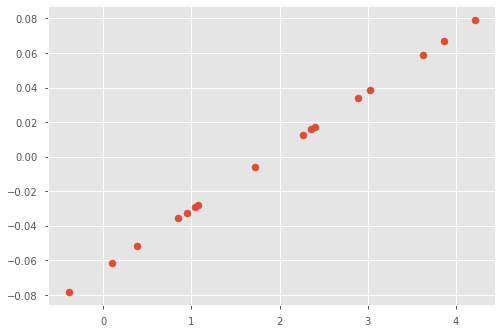

In [35]:
plt.scatter(x, influence_slope(x))

In [36]:
# we will actually do least square, i.e. statsmodel
b_hat = []
for i in range (0, len(x)):
    new_y = y.copy()
    new_y[i] += 1
    x_sm = sm.add_constant(x)
    res = sm.GLM(new_y, x_sm).fit()
    print(f"b_hat is {res.params[1]}")
    b_hat.append(res.params[1])

b_hat is 3.0777293592899007
b_hat is 3.0945027710360815
b_hat is 3.0246706078479004
b_hat is 3.13968828839314
b_hat is 3.098952859866701
b_hat is 3.1194917313926354
b_hat is 3.032543841932843
b_hat is 2.9822236066943013
b_hat is 3.12770728000301
b_hat is 3.073279270459282
b_hat is 3.008581825152585
b_hat is 3.031174583831114
b_hat is 3.076360101188172
b_hat is 3.054451971560508
b_hat is 2.998997018440482
b_hat is 3.0280937531022243


In [37]:
true_res = sm.GLM(y,x_sm).fit()

In [38]:
b_true = sm.GLM(y,x_sm).fit().params[1]

In [39]:
b_true

3.06052805438693

In [40]:
np.array(b_hat)-b_true

array([ 0.0172013 ,  0.03397472, -0.03585745,  0.07916023,  0.03842481,
        0.05896368, -0.02798421, -0.07830445,  0.06717923,  0.01275122,
       -0.05194623, -0.02935347,  0.01583205, -0.00607608, -0.06153104,
       -0.0324343 ])

In [41]:
influence_slope(x)

0     0.017201
1     0.033975
2    -0.035857
3     0.079160
4     0.038425
5     0.058964
6    -0.027984
7    -0.078304
8     0.067179
9     0.012751
10   -0.051946
11   -0.029353
12    0.015832
13   -0.006076
14   -0.061531
15   -0.032434
Name: growth, dtype: float64

In [42]:
np.array(b_hat)-b_true - influence_slope(x)

0    -4.961309e-16
1    -2.706169e-16
2    -7.979728e-16
3     2.775558e-16
4    -2.775558e-17
5    -1.235123e-15
6    -1.595946e-16
7     4.163336e-17
8    -6.383782e-16
9     1.457168e-16
10   -2.289835e-16
11    3.816392e-17
12   -2.949030e-16
13    2.151057e-16
14    2.636780e-16
15    4.857226e-16
Name: growth, dtype: float64

# 8.7 Least squares slope as a weighted average of individual slopes

Just a math exercise, but is actually difficult, the key is to recognize that $\sum_{i}^{n} x = n\overline{x}$

# 8.8 Comparing `pymc3` and `statsmodel`

In [43]:
x = np.random.uniform(0,20,100)
error = np.random.normal(0,5,100)
y = 2+3*x+error

In [44]:
x_sm = sm.add_constant(x)
res = sm.GLM(y, x_sm).fit()

In [45]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          22.426
Method:                          IRLS   Log-Likelihood:                -296.40
Date:                Sun, 30 May 2021   Deviance:                       2197.8
Time:                        13:21:20   Pearson chi2:                 2.20e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4364      0.998      1.439      0.150      -0.520       3.393
x1             3.0117      0.083     36.331      0.000       2.849       3.174
==============================================================================
"""

In [46]:
with pm.Model() as model:
    pm.glm.GLM(x,y,intercept=True)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sd, x0, Intercept]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.9060540738779924, but should be close to 0.8. Try to increase the number of tuning steps.


/home/jfyu/miniconda3/envs/ros/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b630b9dc0>,
      dtype=object)

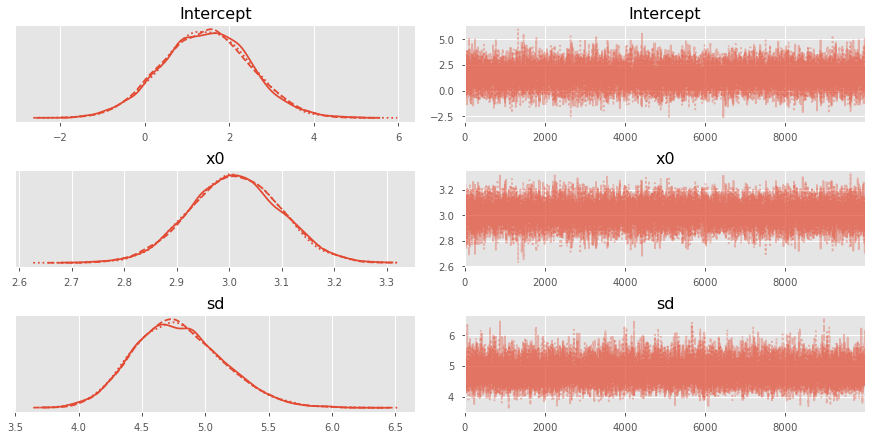

In [47]:
pm.traceplot(trace)

In [72]:
intercept = np.mean(trace[:3000]['Intercept'])
intercept

1.4565430224587248

In [73]:
slope = np.mean(trace[:3000]['x0'])
slope

3.0102828119331835

In [74]:
np.mean(trace['sd'])

4.791207231303886

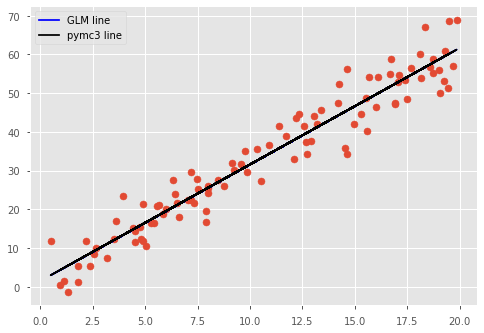

In [52]:
plt.scatter(x,y)
plt.plot(x, res.params[0]+res.params[1]*x, color= 'b', label='GLM line')
plt.plot(x, intercept+slope*x, color='k', label='pymc3 line')
plt.legend()

# 8.9 Leave-one-out cross validation

In [53]:
data

,year,growth,vote,inc_party_candidate,other_candidate
0,1952,2.40,44.60,Stevenson,Eisenhower
1,1956,2.89,57.76,Eisenhower,Stevenson
2,1960,0.85,49.91,Nixon,Kennedy
3,1964,4.21,61.34,Johnson,Goldwater
4,1968,3.02,49.60,Humphrey,Nixon
5,1972,3.62,61.79,Nixon,McGovern
6,1976,1.08,48.95,Ford,Carter
7,1980,-0.39,44.70,Carter,Reagan
8,1984,3.86,59.17,Reagan,Mondale
9,1988,2.27,53.94,"Bush, Sr.",Dukakis


In [54]:
from sklearn.model_selection import LeaveOneOut

In [55]:
loo = LeaveOneOut()

In [56]:
loo.get_n_splits(data['vote'])

16

Can't compare `stan_glm` since we can't figure out how to do that in Python

In [57]:
cv_res_n = []
for train_index, test_index in loo.split(data[['growth', 'vote']]):
    x = data['growth'][train_index]
    y = data['vote'][train_index]
    x_sm = sm.add_constant(x)
    res = sm.GLM(y,x_sm).fit()
    x_test = data['growth'][test_index]
    y_test = data['vote'][test_index]
    cv_residual = y_test - (res.params[0]+res.params[1]*x_test)
    cv_res_n.append(cv_residual.values[0])

In [58]:
cv_res_n

[-9.681707405723408,
 2.9514103314942943,
 1.1788607384887655,
 2.9260420212630294,
 -6.5861499009409386,
 5.339219044567301,
 -0.6593081272868488,
 -0.46684081913613085,
 1.3761544994171118,
 0.7986632670708644,
 -1.002302487164549,
 5.819611658317484,
 -3.4407342808053016,
 -0.29020721086688894,
 -0.28262353123204775,
 3.137350197980574]

In [59]:
sigma_cv = np.sqrt(1/len(cv_res_n)*np.sum(np.power(cv_res_n,2)))

In [60]:
sigma_cv

3.9066037292468696

formula 8.5

In [61]:
sigma_classic = np.sqrt(1/(len(data['growth'])-2)*np.sum(np.power(data['vote'] - (res.params[0]+res.params[1]*data['growth']), 2)))

In [62]:
sigma_classic

3.7719864869488466

In [63]:
sigma_true # this uses 1/n as opposed to 1/(n-2) in the classic case

3.521737852254197

In [64]:
sigma_stan = 3.9 # see sec.7.1

Looks like leave-one-out is the closest to stan. It fixes the overfitting issue that is coming out of the sigma_true, and sigma_classic tries to fix it, but I think the sample size is too small so it did not do a great job

# 8.10 Leave one out cross validation

In [65]:
x_data = np.linspace(-10,10,10)
y_data = 5*x_data+6+np.random.normal(0, 10, 10)

In [66]:
cv_res_n = []
for train_index, test_index in loo.split(x_data):
    x = x_data[train_index]
    y = y_data[train_index]
    x_sm = sm.add_constant(x)
    res = sm.GLM(y,x_sm).fit()
    x_test = x_data[test_index]
    y_test = y_data[test_index]
    cv_residual = y_test - (res.params[0]+res.params[1]*x_test)
    cv_res_n.append(cv_residual[0])

In [67]:
sigma_cv = np.sqrt(1/len(cv_res_n)*np.sum(np.power(cv_res_n,2)))

In [68]:
sigma_cv

15.69707699308483

In [69]:
x_sm = sm.add_constant(x_data)
res = sm.GLM(y_data,x_sm).fit()

In [70]:
sigma_classic = np.sqrt(1/(len(x_data)-2)*np.sum(np.power(y_data - (res.params[0]+res.params[1]*x_data), 2)))

In [71]:
sigma_classic

14.00254448228555

Fewer points. So every point has a larger influence on the line. This would make leave-one-out really large because the residuals would be huge. 